# Direct sampling with Gaussian process regression

#### Import general modules

mpi4py is always required when using these tools. Numpy is always good to have if any manipulation is to be done.

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

import os
os.environ["PYSEMTOOLS_DEBUG"] = 'false'
os.environ["PYSEMTOOLS_HIDE_LOG"] = 'false'

#### Import modules from pysemtools

In this case we will import all the data types that we currently support, as well as io functions that are required to populate them.

In [2]:
# Data types
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.coef import Coef
from pysemtools.datatypes.field import Field, FieldRegistry

# Readers
from pysemtools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pysemtools.io.ppymech.neksuite import pwritenek, pynekwrite

fname = '../data/mixlay0.f00001'

## Read the data

In [3]:
# Read the data
msh = Mesh(comm, create_connectivity=False)
fld = FieldRegistry(comm)
pynekread(fname, comm, data_dtype=np.double, msh = msh, fld = fld)
 
# Get the coefficients
coef = Coef(msh=msh, comm=comm)

2025-02-28 00:59:36,381 - Mesh - INFO - Initializing empty Mesh object.
2025-02-28 00:59:36,383 - Field - INFO - Initializing empty Field object
2025-02-28 00:59:36,383 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2025-02-28 00:59:36,390 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-28 00:59:36,391 - Mesh - INFO - Initializing common attributes.
2025-02-28 00:59:36,392 - Mesh - INFO - Getting vertices
2025-02-28 00:59:36,393 - Mesh - INFO - Getting edge centers
2025-02-28 00:59:36,398 - Mesh - INFO - Facet centers not available for 2D
2025-02-28 00:59:36,399 - Mesh - INFO - Mesh object initialized.
2025-02-28 00:59:36,399 - Mesh - INFO - Mesh data is of type: float64
2025-02-28 00:59:36,400 - Mesh - INFO - Elapsed time: 0.010164617s
2025-02-28 00:59:36,400 - pynekread - INFO - Reading field data
2025-02-28 00:59:36,406 - pynekread - INFO - File read
2025-02-28 00:59:36,407 - pynekread - INFO - Elapsed time: 0.023277116s
2025-02-28 00:59:36,407 - Coe

## Compress the data with GPR

### Method 1

Average the data across multiple elements and use that as the covariance. Then sample to enhance the results

### Initialize the Direct sampler

In [4]:
from pysemtools.compression.gpc_direct_sampling import DirectSampler

# Initialize a sampler with numpy (default)
ds = DirectSampler(comm=comm, msh=msh)

2025-02-28 00:59:36,477 - DirectSampler - INFO - Initializing the DirectSampler from a Mesh object


### Sample the data

Sample the data using avergaes to determine the covariance

In [5]:
# Select the options
n_samples = 24
bitrate = n_samples/(msh.lx*msh.ly*msh.lz)
ds.log.tic()
ds.sample_field(field=fld.registry["u"], field_name="u", covariance_method="average", covariance_elements_to_average=100, compression_method="fixed_bitrate", bitrate = bitrate)
ds.log.toc()

2025-02-28 00:59:36,491 - DirectSampler - INFO - Sampling the field with options: covariance_method: {covariance_method}, compression_method: {compression_method}
2025-02-28 00:59:36,492 - DirectSampler - INFO - Estimating the covariance matrix
2025-02-28 00:59:36,492 - DirectSampler - INFO - Transforming the field into to legendre space
2025-02-28 00:59:36,496 - DirectSampler - INFO - Estimating the covariance matrix using the averaging method method. Averaging over 100 elements at a time
2025-02-28 00:59:36,498 - DirectSampler - INFO - Covariance saved in field uncompressed_data["u"]["kw"]
2025-02-28 00:59:36,498 - DirectSampler - INFO - Covariance matrix estimated with settings: {'method': 'average', 'elements_to_average': 100, 'averages': 16, 'kw_diag': True}
2025-02-28 00:59:36,499 - DirectSampler - INFO - Sampling the field using the fixed bitrate method. using settings: {'method': 'fixed_bitrate', 'bitrate': np.float64(0.375), 'n_samples': 24}
2025-02-28 00:59:36,500 - DirectSam

### Write out and visualize the uncertainty

To write the uncertainty, it is best to do it before encoding. It is at this time that the original data is available. Correctly determining the uncertianty after this might be more problematic unless a good model of the covariances is present

In [6]:
fld_out = FieldRegistry(comm)

_, u_std = ds.reconstruct_field(field_name = "u", get_std = True, unsampled_field_available=True)

fld_out.add_field(comm, field_name="s", field=u_std, dtype=np.single)
pynekwrite("u_std_averages0.f00001", comm, msh = msh, fld = fld_out)

2025-02-28 00:59:38,346 - Field - INFO - Initializing empty Field object
2025-02-28 00:59:38,357 - DirectSampler - INFO - Proccesing up to 1600/1600 element
2025-02-28 00:59:38,511 - Field - WARNING - Field s has dtype float64 but expected <class 'numpy.float32'>
2025-02-28 00:59:38,512 - Field - WARNING - Field s will be casted to <class 'numpy.float32'>
2025-02-28 00:59:38,513 - pynekwrite - INFO - Writing file: u_std_averages0.f00001
2025-02-28 00:59:38,517 - pynekwrite - INFO - Elapsed time: 0.003996857000000187s


### Visualize it!

Since this is a 2D field, we can easily visualize it in python, but for this case, we show how it looks in visit:

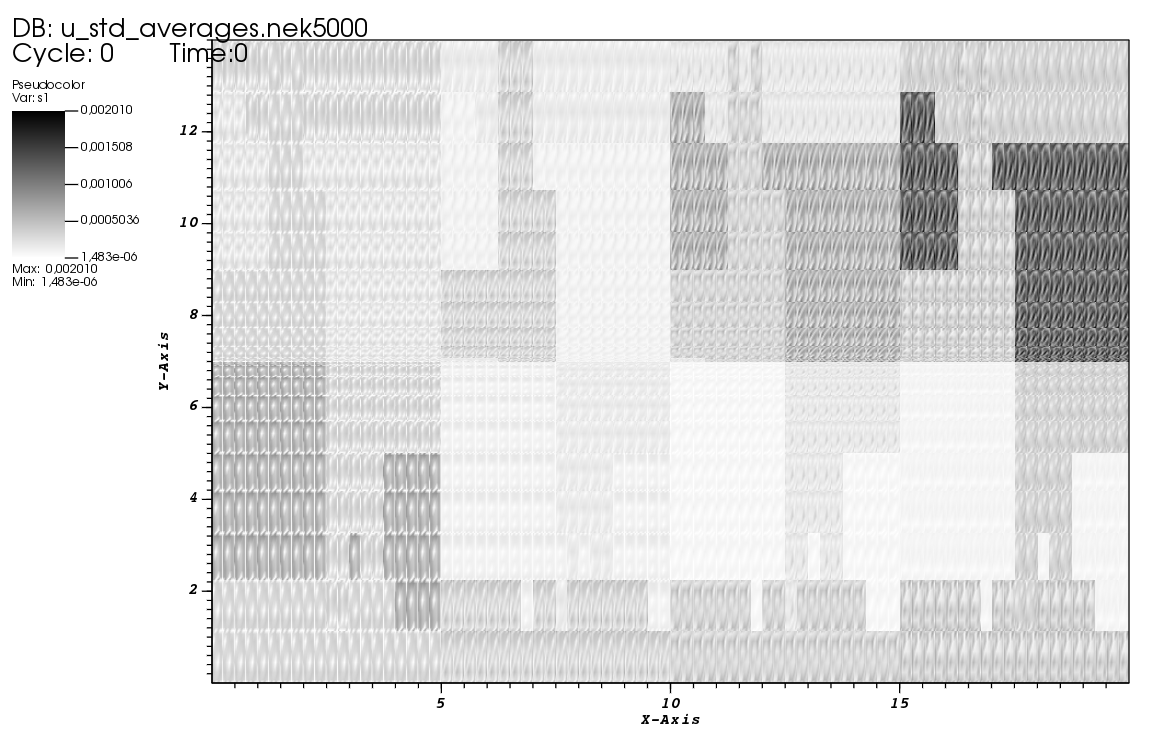

Note that the uncertainty depends on the approximation of the covariance. Since we are using averages, it is clear that the uncertainty follows the elements over which we average

### Encode it

The data that needs to be compressed for this method is stored in the directory ds.uncompressed_data. We can now encode it with bzip2

In [7]:
ds.compress_samples(lossless_compressor="bzip2")

2025-02-28 00:59:38,526 - DirectSampler - INFO - Compressing the data using the lossless compressor: bzip2
2025-02-28 00:59:38,527 - DirectSampler - INFO - Compressing data in uncompressed_data
2025-02-28 00:59:38,527 - DirectSampler - INFO - Compressing data for field ["u"]:
2025-02-28 00:59:38,528 - DirectSampler - INFO - Compressing ["kw"] for field ["u"]
2025-02-28 00:59:38,533 - DirectSampler - INFO - Compressing ["field"] for field ["u"]


### Write it out

Write out the compressed file

In [8]:
ds.write_compressed_samples(comm=comm, filename="test")

2025-02-28 00:59:38,663 - DirectSampler - INFO - Parallel HDF5 not available; creating folder to store rank files.


## Decompress the data

Just to show, let's see how the uncompression process works.

### Read the data

First we must read the data. In this process, it will be first read as a bzip compressed byte object. At this step it will be unencoded but still not be a cfd field.

In [9]:
ds_read = DirectSampler(comm, filename="test")

2025-02-28 00:59:38,677 - DirectSampler - INFO - Initializing the DirectSampler from file: test


### Reconstruct the data from the samples

In [10]:
u_np, u_std_np = ds_read.reconstruct_field(field_name="u", get_mean=True, get_std=True)

2025-02-28 00:59:38,740 - DirectSampler - INFO - Proccesing up to 1600/1600 element


## Visualize the data

In [11]:
# General settings

u = fld.registry["u"]
u_levels = np.linspace(np.min(u), np.max(u), 100)
err_levels = np.linspace(0, 0.001, 100)

### See the data and the errors.

Keep in mind that the uncertainty shown here is not super accurate, given that at this stage, we have already discarded the original data. If you want to keep the uncertainty exactly, write it a compression time.

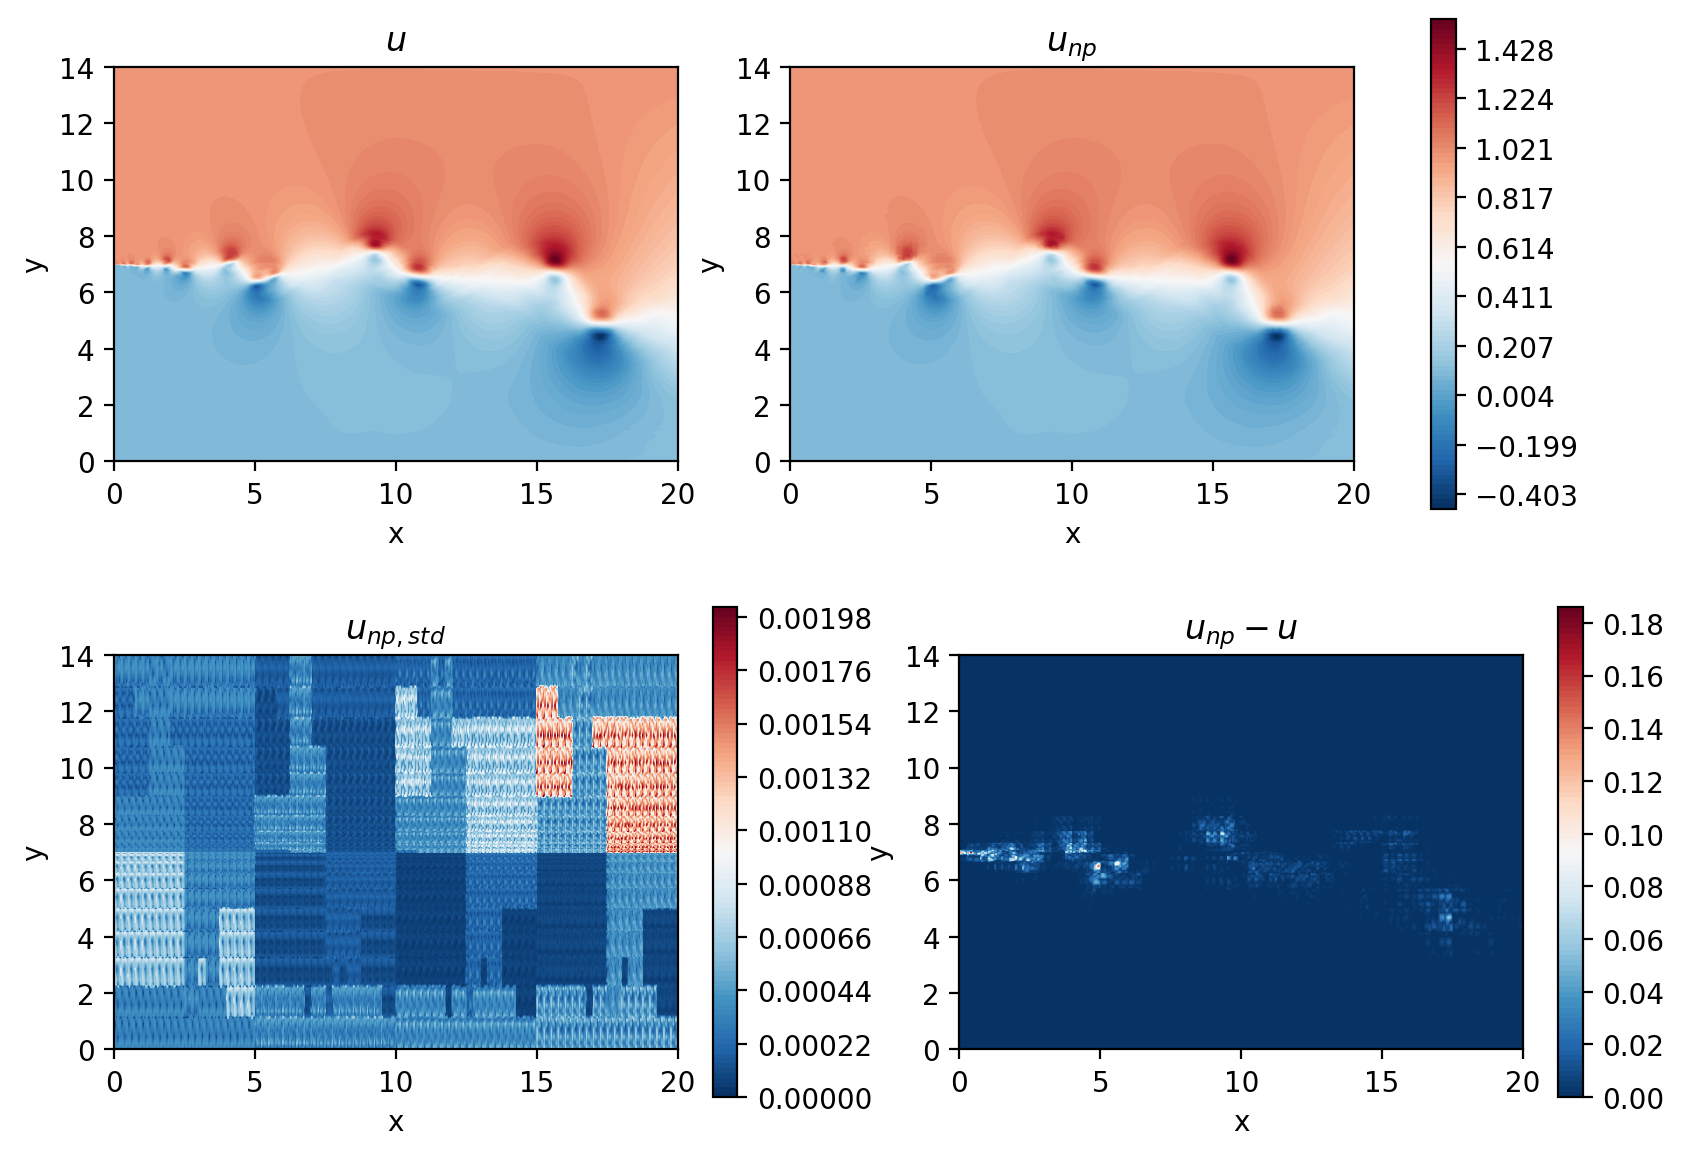

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,fld.registry["u"].flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$u$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_np.flatten(), levels=u_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$u_{np}$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,u_std_np.flatten(), levels=100, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$u_{np,std}$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,np.sqrt((u_np.flatten()- u.flatten())**2), levels=100, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$u_{np} - u$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,0])
cbar11=fig.colorbar(c11, ax=ax[1,1])
plt.show()

## Test the derivative

Just for completion, check if the derivatives look okay

In [13]:
# Initiate the mesh partitioning
from pysemtools.datatypes.msh_connectivity import MeshConnectivity

msh_conn = MeshConnectivity(comm, msh = msh, use_hashtable=True)

dudx = coef.dudxyz(u, coef.drdx, coef.dsdx)
dudy = coef.dudxyz(u, coef.drdy, coef.dsdy)

dudx_np = coef.dudxyz(u_np, coef.drdx, coef.dsdx)
dudy_np = coef.dudxyz(u_np, coef.drdy, coef.dsdy)

dudx_levels = np.linspace(-2.5, 3.1, 100)
dudy_levels = np.linspace(-4.6, 7.6, 100)

2025-02-28 00:59:45,622 - MeshConnectivity - INFO - Initializing MeshConnectivity
2025-02-28 00:59:45,623 - MeshConnectivity - INFO - Computing local connectivity
2025-02-28 00:59:45,734 - MeshConnectivity - INFO - Computing global connectivity
2025-02-28 00:59:45,736 - MeshConnectivity - INFO - Computing multiplicity
2025-02-28 00:59:45,764 - MeshConnectivity - INFO - MeshConnectivity initialized
2025-02-28 00:59:45,765 - MeshConnectivity - INFO - Elapsed time: 0.14205287099999886s
2025-02-28 00:59:45,766 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-28 00:59:45,774 - Coef - INFO - done
2025-02-28 00:59:45,775 - Coef - INFO - Elapsed time: 0.00812067600000077s
2025-02-28 00:59:45,775 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-28 00:59:45,783 - Coef - INFO - done
2025-02-28 00:59:45,783 - Coef - INFO - Elapsed time: 0.007649763999999948s
2025-02-28 00:59:45,784 - Coef - INFO - Calculating the derivat

### Visualize

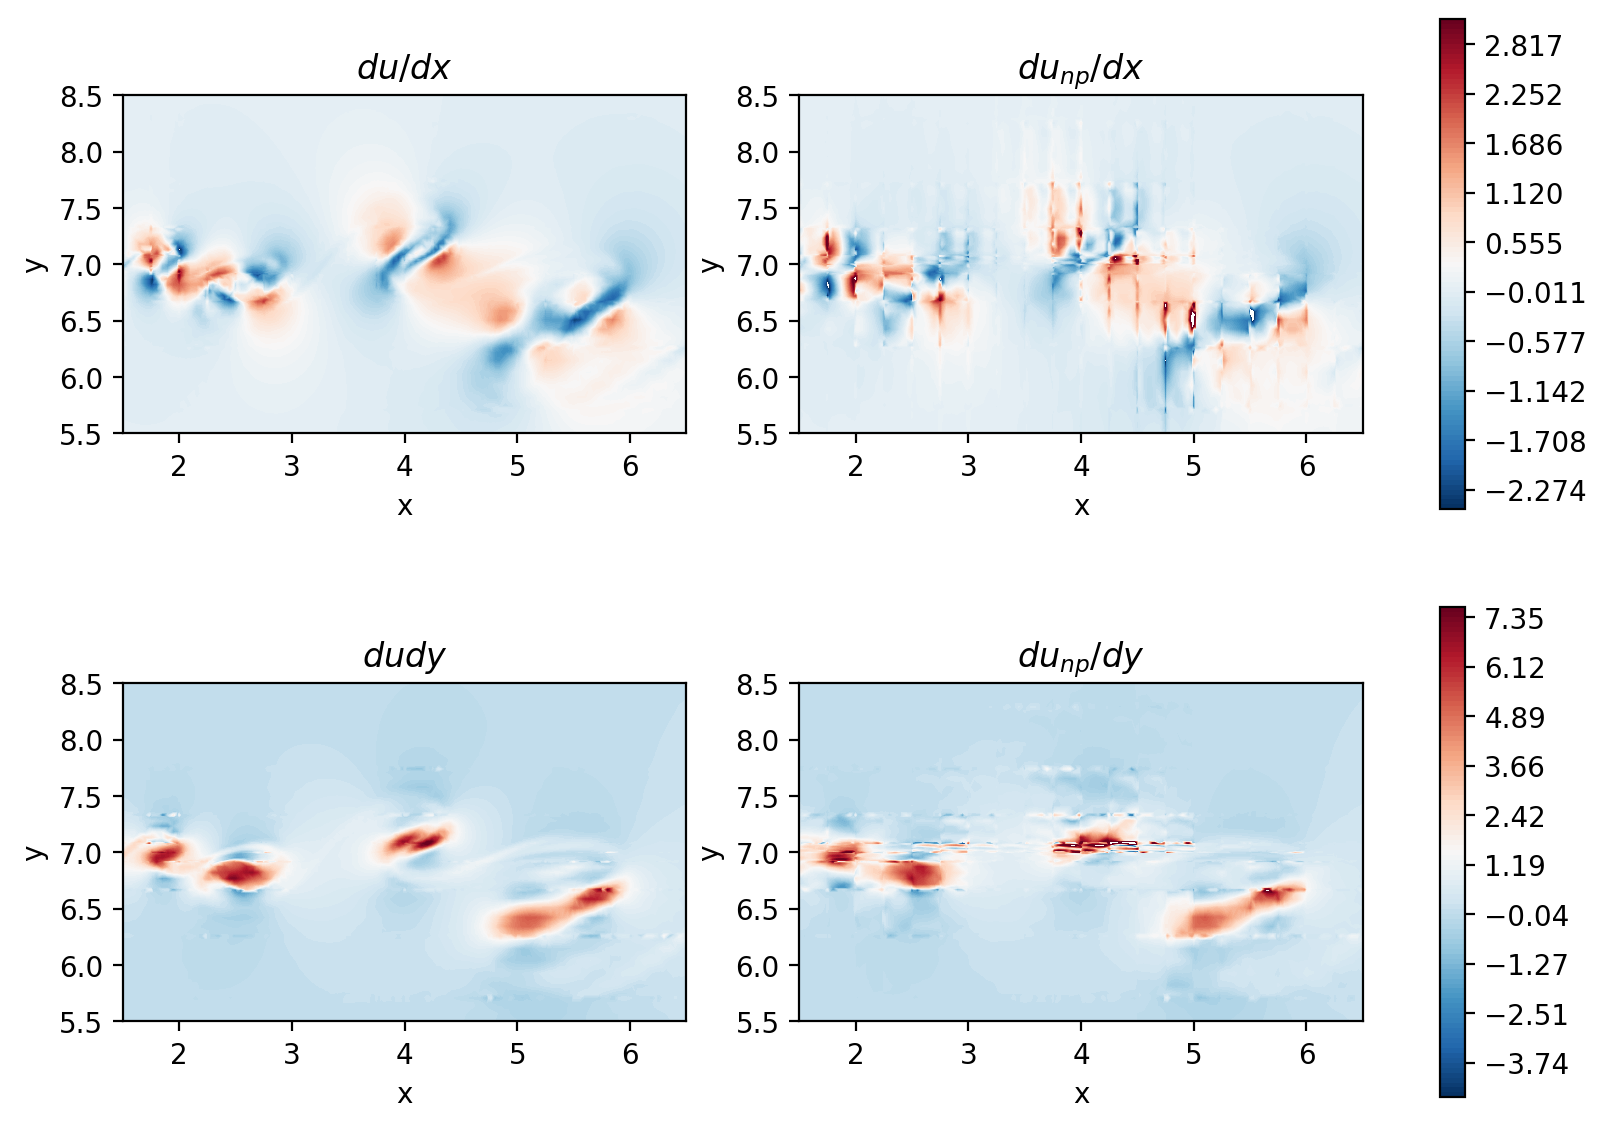

In [14]:

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 7), dpi = 200)

c00 = ax[0,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,0].set_aspect('equal')
ax[0,0].set_xlabel("x")
ax[0,0].set_ylabel("y")
ax[0,0].set_title(r"$du/dx$")

c01 = ax[0,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudx_np.flatten(), levels=dudx_levels, cmap="RdBu_r")
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel("x")
ax[0,1].set_ylabel("y")
ax[0,1].set_title(r"$du_{np}/dx$")

c10 = ax[1,0].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,0].set_aspect('equal')
ax[1,0].set_xlabel("x")
ax[1,0].set_ylabel("y")
ax[1,0].set_title(r"$dudy$")

c11 = ax[1,1].tricontourf(msh.x.flatten(), msh.y.flatten() ,dudy_np.flatten(), levels=dudy_levels, cmap="RdBu_r")
ax[1,1].set_aspect('equal')
ax[1,1].set_xlabel("x")
ax[1,1].set_ylabel("y")
ax[1,1].set_title(r"$du_{np}/dy$")

cbar0=fig.colorbar(c00, ax=ax[0,:])
cbar10=fig.colorbar(c10, ax=ax[1,:])


ax[0,0].set_xlim([1.5,6.5])
ax[0,0].set_ylim([5.5,8.5])

ax[0,1].set_xlim([1.5,6.5])
ax[0,1].set_ylim([5.5,8.5])

ax[1,0].set_xlim([1.5,6.5])
ax[1,0].set_ylim([5.5,8.5])

ax[1,1].set_xlim([1.5,6.5])
ax[1,1].set_ylim([5.5,8.5])

plt.show()